# Multi-layered Nengo SNN

### From One-Layered Wave to Multi-layered Network
Before this notebook, we had successfully made a custom Nengo neuron type with our LIF threshold and voltage rules that generated waves from noise. Now, we sought to scale up and add other layers. This meant determining how to connect layers and implement a custom learning rule in Nengo according to our algorithm.

#### Adding Connections:
When writing this notebook, I was researching how to connect layers in Nengo according to our update rules. Our original custom neuron type did not involve the input from a previous layer, which is obviously necessary if we are to have multi-layered networks. With the help of the Nengo <a href="https://forum.nengo.ai/t/what-do-the-connection-inputs-and-outputs-mean/1275/4" target="_blank">forum</a>, we added to our custom LIF neuron type to include inputs from the previous layer (and the winner-take-all rule in the paper). Additionally, we had to make a distinction between first layer neurons and higher layer neurons since first layer neurons do not take input from previous layers and higher layer neurons do not take in noise, among some other differences. I chose to make separate classes of neurons, but these could also be implemented as one class with additional parameters, if preferred/if other custom neuron types besides LIF will be added in the future. 
The custom neuron types are CustomLIF in L1_Neuron.py (first/Retina layer) and LGNLIF in L2_Neuron.py (higher layers), which are imported from separate .py files. 

#### Checking Wave Dynamics
After adding the connections, we tested that the wave propagates to higher layers. This was before adding a learning rule.

#### Custom Learning Rule
We now had a multi-layered network, but the weights were the same throughout the simulation because there was no learning rule. We implemented a simple STDP learning rule as described in the paper, again, with the help of the <a href="https://forum.nengo.ai/t/custom-hebbian-learning-rule-confusion/1361/2" target = "_blank">forum</a>. This was done by modifying the existing Nengo Oja learning rule and its builder. 

#### Checking Threshold and Voltage Dynamics
Since our first implementation of our algorithm in Nengo, the spatiotemporal wave dynamics were as expected, but the threshold and voltage dynamics differed. We thought that this could be because of differences in Nengo related to time (dt) and how spikes are represented. For example, in Nengo's <a href="https://www.nengo.ai/nengo/_modules/nengo/neurons.html#Izhikevich" target = "_blank">Izhikevich model</a>, the change in voltage, `dV`, includes a product of `dt` and `1000`. In Nengo, the default value for `dt` is .001, so multiplying `dt` by 1000 is just multiplying by 1. However, dt can change, whereas the 1000 is set. Additionally, spikes in Nengo have a value of 1/dt, so they are represented as 1000 instead of 1, which is what our MATLAB version does.

To fix the threshold and voltage dynamics, we changed parts of our custom neuron type that was leftover from the Nengo LIF implementation that wasn't relevant to our algorithm, like the `refractory_time` variable, rectifying negative voltages to a minimum value. We also decided to test networks with `dt=.01`, and modified our custom neuron type to represent spikes as 100, and to multiply `dV` and `dTh` by 100. These changes caused the voltage and threshold dynamics to more closely match our intended dynamics than the ones seen in the "1-layer nengo wave" file. 

In terms of the learning rule, our MATLAB version ends up adding .01 to the weights between neurons that spike at the same time. In order to keep this value with our varied way of representing spikes, the learning rule adds a vaue that is a product of the learning rate, `dt`, and the pre and post spikes. Since the spikes are scaled by `1/dt`, they are 100 in our case. So for a pre and post neuron that are both spiking, we have 100 * 100 * 1/100 * learning_rate as our change in the weight. Therefore, we chose a learning rate of .0001, so that the change in weight would be .01, as in our MATLAB version. Implementing the learning rule this way caused pooling in-between layers. 

Note: this notebook, and the current L1 and L2 neuron types, are made to take in nondimensional parameters. For the original (not nondimensional) version, see 'rachelfinalSNN'

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import pdist, squareform
from IPython.display import clear_output
%matplotlib inline
from nengo.utils.matplotlib import rasterplot

import nengo
from nengo.params import Parameter, NumberParam, NdarrayParam
from nengo.neurons import settled_firingrate  
from nengo.neurons import LIFRate, NeuronType

In [50]:
from L1_Neuron import CustomLIF
from L2_Neuron import LGNLIF
from LRs import STDP, STDP2

In [51]:
nR = 1600
nL = 512
nV = 400

In [52]:
weights = np.array([[1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 1]])
# np.random.randn(3,3)
W1 = np.random.normal(2.5, .14, (nR,nL))
W1 = W1/np.mean(W1, axis = 0) * 2.5    # Weight Matrix between Retina-LGN1 normrnd initialized take column mean
W1 = W1.T

In [53]:
# need to make Ss, nR, tau_v, piT_th, piTV_plus, piV_th,piV_reset,nxs, Vt for a

# need to make Ss, nL, tau_v, piT_th, piTV_plus, piV_th, piV_reset, nxs, Vt, S_x, and thresh for b.
# try to do this in a better way 

# maybe a function that returns a dictionary of the values needed and calculates them?

def l1_params(num, sq, ri, ro, lam, ai, ao, tau_v, tau_th, th_plus, v_th):
    params = {}
    v_reset = (0+0.1*(np.random.randn(num,))**2) * 100 # Noise on activity field
    # Spatial Parameters

    nx = sq*np.random.rand(num,2)

    # Dynamics parameters

    # Nondimensional parameters
    Vt, Tt, Lt = ao, tau_v, sq

    # Nondimensional groups
    piTV_plus = th_plus * Tt / Vt
    piT_th = Tt / tau_th 

    piV_th = v_th / Vt
    piV_reset = v_reset / Vt;
    piV_ai = ai / Vt

    piL_ri = ri / Lt
    piL_ro =  ro / Lt
    piL_lam = lam / Lt
    
    # Non-dimensional Spatial Adjacency matrix
    nxs = nx / Lt;
    Ds = squareform(pdist(nxs))     # Non-dimensional distance matrix
    Ss = piV_ai *(Ds < piL_ri) - (Ds > piL_ro) * np.exp(-Ds / piL_lam); 
    Ss = Ss - np.diag(np.diag(Ss));      # Adjacency matrix between Neurons in Retina
    
    params["Ss"] = Ss
    params["num"] = num
    params["tau_rc"] = tau_v
    params["piT_th"] = piT_th
    params["piTV_plus"] = piTV_plus
    params["piV_th"] = piV_th
    params["piV_reset"] = piV_reset 
    params["nxs"] = nxs
    params["Vt"] = Vt
    return params


In [54]:
# need to make Ss, nR, tau_v, piT_th, piTV_plus, piV_th,piV_reset,nxs, Vt for a

# need to make Ss, nL, tau_v, piT_th, piTV_plus, piV_th, piV_reset, nxs, Vt, S_x, and thresh for b.
# try to do this in a better way 

# maybe a function that returns a dictionary of the values needed and calculates them?

def l2_params(num, sq, ri, ro, lam, ai, ao, tau_v, tau_th, th_plus, v_th, mu_thresh, sigma_thresh):
    params = {}
    v_reset = (0+0.1*(np.random.randn(num,))**2) * 100 # Noise on activity field
    # Spatial Parameters

    nx = sq*np.random.rand(num,2)

    # Dynamics parameters

    # Nondimensional parameters
    Vt, Tt, Lt = ao, tau_v, sq

    # Nondimensional groups
    piTV_plus = th_plus * Tt / Vt
    piT_th = Tt / tau_th 

    piV_th = v_th / Vt
    piV_reset = v_reset / Vt;
    piV_ai = ai / Vt

    piL_ri = ri / Lt
    piL_ro =  ro / Lt
    piL_lam = lam / Lt
    
    # Non-dimensional Spatial Adjacency matrix
    nxs = nx / Lt;
    Ds = squareform(pdist(nxs))     # Non-dimensional distance matrix
    Ss = piV_ai *(Ds < piL_ri) - (Ds > piL_ro) * np.exp(-Ds / piL_lam); 
    Ss = Ss - np.diag(np.diag(Ss));      # Adjacency matrix between Neurons in Retina
    
    # non-dimensional LGN layer stuff
    S_x = piV_ai *(Ds < (piL_ri/100)) - (Ds > (piL_ro/100)) * np.exp(-Ds / piL_lam); 
    S_x = S_x - np.diag(np.diag(S_x));      # Adjacency matrix between Neurons 

    thresh = np.random.normal(mu_thresh, sigma_thresh, (num,))

    
    params["Ss"] = Ss
    params["num"] = num
    params["tau_rc"] = tau_v
    params["piT_th"] = piT_th
    params["piTV_plus"] = piTV_plus
    params["piV_th"] = piV_th
    params["piV_reset"] = piV_reset
    params["nxs"] = nxs
    params["Vt"] = Vt
    params["S_x"] = S_x
    params["thresh"] = thresh
    
    return params


In [55]:
retina = l1_params(num=1600, sq=28, ri=3, ro=6, lam=10, ai=30, ao=10, tau_v=1, tau_th=30, th_plus=9, v_th=1)
lgn = l2_params(num=512, sq=10, ri=1.2, ro=1.5, lam=10, ai=30, ao=10, tau_v=1, tau_th=10, th_plus=6, v_th=1, mu_thresh = 40, sigma_thresh = 2)
v1 = l2_params(num=400, sq=10, ri=1.2, ro=1.5, lam=10, ai=30, ao=10, tau_v=1, tau_th=10, th_plus=6, v_th=1, mu_thresh = 40, sigma_thresh = 2)


In [56]:
1.2/10

0.12

In [57]:
retina["piT_th"]

0.03333333333333333

In [58]:
lgn["piT_th"]

0.1

In [59]:
a = 3*np.random.randn(4,) / 10

In [60]:
(lgn["Ss"] > 0).sum()

10750

In [61]:
W2 = np.random.normal(2.5, .14, (nL,nV))
W2 = W2/np.mean(W2, axis = 0) * 2.5    # Weight Matrix between Retina-LGN1 normrnd initialized take column mean
W2 = W2.T

In [62]:


model = nengo.Network(label='2D Representation', seed=10)

with model:
    # node = nengo.Node(np.sin)
    # a = nengo.Ensemble(nR, dimensions=1, neuron_type=CustomLIF(Ss, nR, tau_v, piT_th, piTV_plus, piV_th,
    #                                                            piV_reset,nxs, Vt, wave = True), label = "a")
    
    
#     b = nengo.Ensemble(nL, dimensions=1, neuron_type=LGNLIF(Ss, S_x, nL, tau_v, piT_th, piTV_plus, piV_th,
#                                                              piV_reset,nxs, Vt, thresh, wave=False), label = "b")

# nengo.LIF()

    a = nengo.Ensemble(nR, dimensions=1, neuron_type = CustomLIF(*retina.values(), wave=False), label="a")
    b = nengo.Ensemble(nL, dimensions=1, neuron_type = LGNLIF(*lgn.values(), wave=False), label="a")
    c = nengo.Ensemble(nV, dimensions=1, neuron_type = LGNLIF(*v1.values(), wave=False), label="a")
    conn = nengo.Connection(a.neurons, b.neurons, transform = W1, synapse = None)
    conn2 = nengo.Connection(b.neurons, c.neurons, transform = W2, synapse = None)

    
#     conn.learning_rule_type=nengo.Oja(pre_synapse=None, post_synapse=None)
#     conn2.learning_rule_type=nengo.Oja(pre_synapse=None, post_synapse=None)
#     conn.learning_rule_type=nengo.Oja()
#     conn2.learning_rule_type=nengo.Oja()
   
    conn.learning_rule_type=STDP()
    conn2.learning_rule_type=STDP()
 
    LR_pre = nengo.Probe(conn.learning_rule, "pre_filtered")
    LR_post = nengo.Probe(conn.learning_rule, "post_filtered")
    delta_probe = nengo.Probe(conn.learning_rule, "delta")
    weights_probe = nengo.Probe(conn, "weights")

    
    spikes_probe = nengo.Probe(a.neurons, 'spikes')
    voltage_probe = nengo.Probe(a.neurons, 'voltage')
    threshold_probe = nengo.Probe(a.neurons, 'threshold')
    
    b_spikes = nengo.Probe(b.neurons, 'spikes')
    b_voltage = nengo.Probe(b.neurons, 'voltage')
    b_threshold = nengo.Probe(b.neurons, 'threshold')
    
    c_spikes = nengo.Probe(c.neurons, 'spikes')
    c_voltage = nengo.Probe(c.neurons, 'voltage')
    c_threshold = nengo.Probe(c.neurons, 'threshold')

    conn_out = nengo.Probe(conn, 'output')
    conn_in = nengo.Probe(conn, 'input')

with nengo.Simulator(model, dt = .01) as sim:
    sim.run(.8)
    


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [63]:
sim.data[delta_probe].shape

(80, 512, 1600)

### Post-Simulation Analysis
#### Voltage, Threshold, and Spikes of the three Layers

In [64]:
def plot_probes(name, sim, voltage_probe, threshold_probe, spikes_probe):
    plt.figure(figsize=(12, 6))
    plt.plot(sim.trange(), sim.data[voltage_probe])
    plt.xlabel('time [s]')
    plt.ylabel(name + ' voltage')
    
    plt.figure(figsize=(12, 6))
    plt.plot(sim.trange(), sim.data[threshold_probe])
    plt.xlabel('time [s]')
    plt.ylabel(name + ' threshold voltage')
    
    plt.figure(figsize=(12, 6))
    rasterplot(sim.trange(), sim.data[spikes_probe])
    plt.xlabel('time [s]')
    plt.ylabel('Neuron number (spikes)')

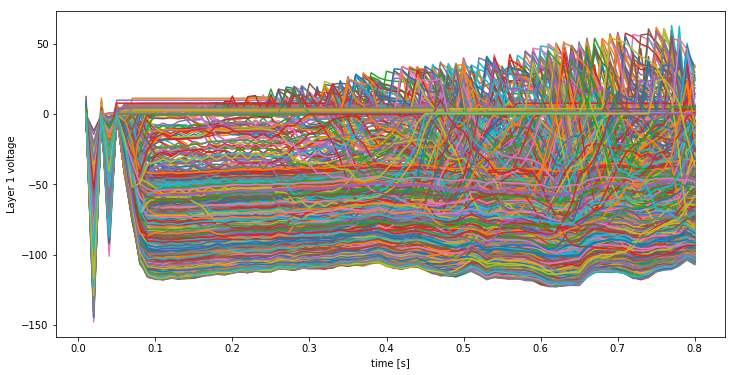

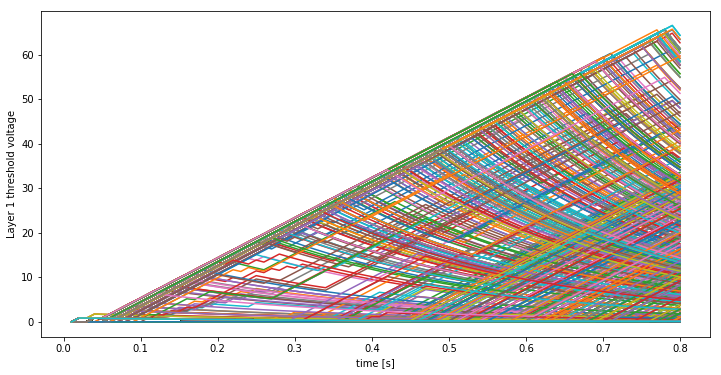

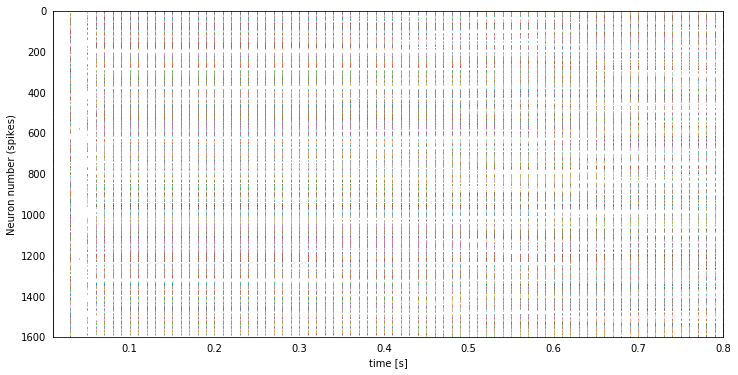

In [65]:
# Plotting Retina
plot_probes("Layer 1", sim, voltage_probe, threshold_probe, spikes_probe)

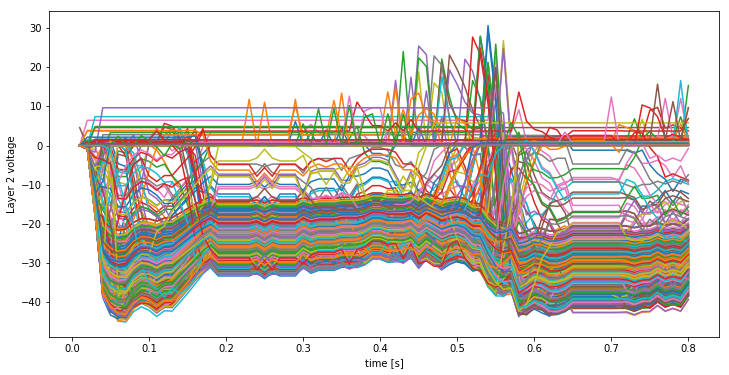

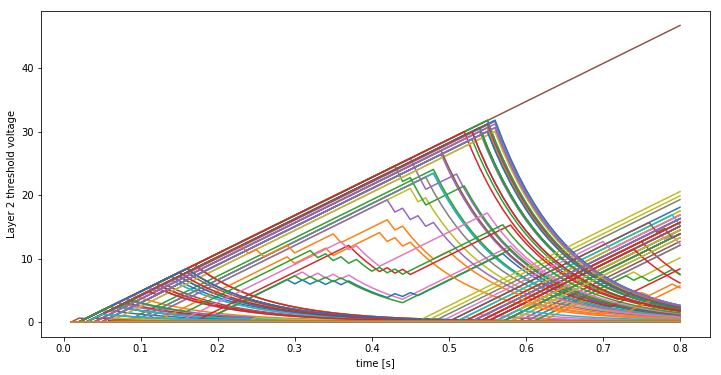

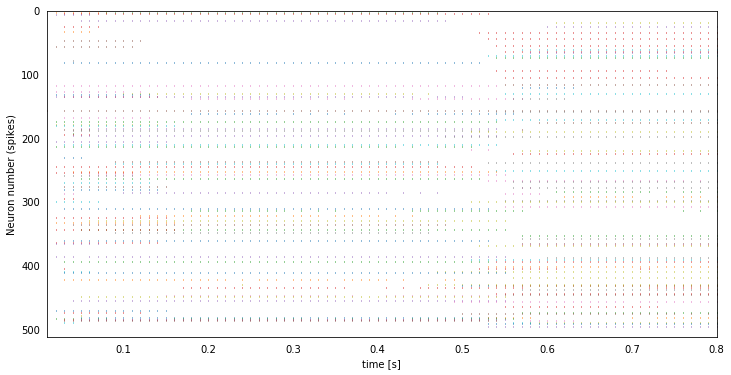

In [66]:
# Plotting LGN
plot_probes("Layer 2", sim, b_voltage, b_threshold, b_spikes)

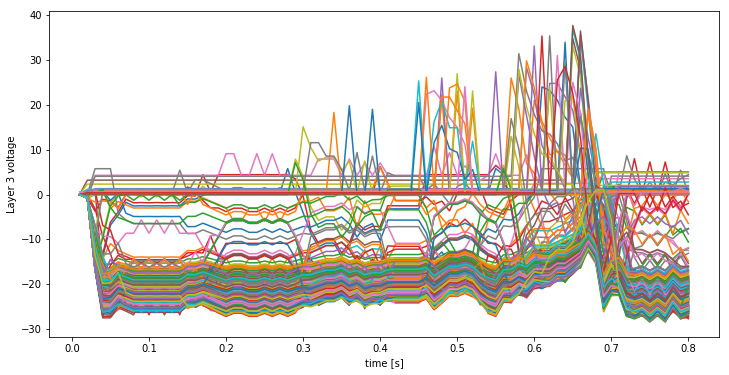

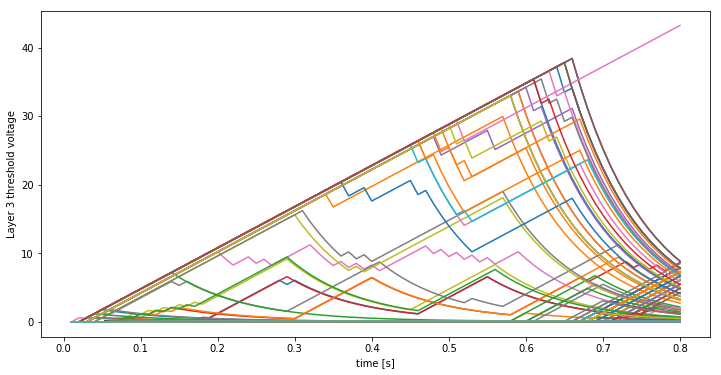

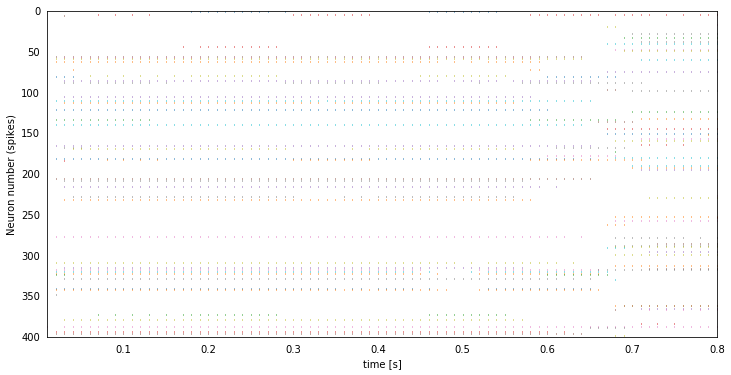

In [67]:
# Plotting V1
plot_probes("Layer 3", sim, c_voltage, c_threshold, c_spikes)

### Change in Ret-LGN weights during "training"
Running the following code block shows how the LGN layer pools (or not) to retina. Each step shows the retina connections to a different LGN neuron. Each dot is a retina neuron, colored by the value of its weight to the LGN neuron specified in the title. Running the block, there are certain LGN neurons that have a pooling architecture to the retina layer (a pattern of positions that are higher in weight than others)

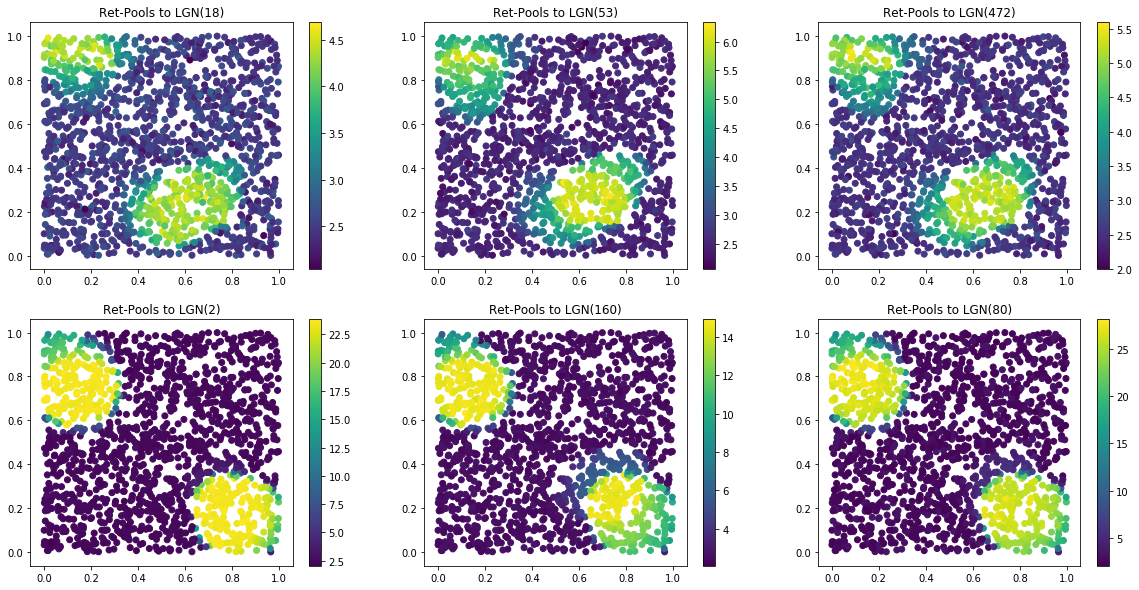

In [93]:
# how finished ret-LGN weights (after 'training') pool (or not) to retina
# each step is retina connections to a different LGN neuron
W1end = sim.data[weights_probe][-1]
plt.figure(figsize=(20, 10))

for i, index in enumerate([18, 53, 472, 2, 160, 80]): 
    plt.subplot(2, 3, i+1)

    #index = 10 # LGN neuron that we are taking W1 slice from
    # connectivity from retina layer to LGN "index" neuron
    plt.scatter(retina["nxs"][:,0], retina["nxs"][:,1], c = W1end[index, :])
    plt.title('Ret-Pools to LGN(' + str(index) + ')')
    plt.colorbar()



In [ ]:
W1end = sim.data[weights_probe][-1]
for index in range(512):
    #index = 10 # LGN neuron that we are taking W1 slice from
    # connectivity from retina layer to LGN "index" neuron
    plt.scatter(retina["nxs"][:,0], retina["nxs"][:,1], c = W1end[index, :])
    plt.title('Ret-Pools to LGN =' + str(index))
    plt.colorbar()
    plt.show()
    clear_output(wait=True)



### Change in LGN-Ret weights during "training"
Running the following code block shows how the Ret layer pools (or not) to LGN. Each step shows the LGN connections to a different Ret neuron. Each dot is an LGN neuron, colored by the value of its weight to the Retina neuron specified in the title. Running the block, there are certain Ret neurons that have a pooling architecture to the retina layer (a pattern of positions that are higher in weight than others)

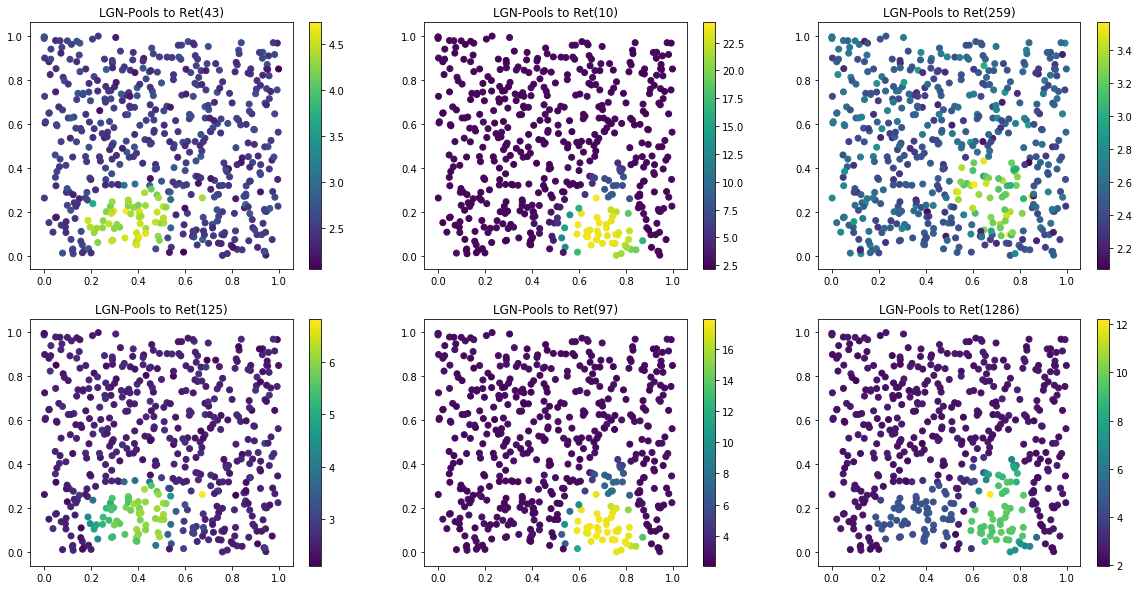

In [116]:
# LGN TO RET
# each step is retina connections to a different LGN neuron
W1end = sim.data[weights_probe][-1]
plt.figure(figsize=(20, 10))

for i, index in enumerate([43, 10, 259, 125, 97, 1286]):
    plt.subplot(2, 3, i+1)

    #index = 10 # LGN neuron that we are taking W1 slice from
    # connectivity from retina layer to LGN "index" neuron
    plt.scatter(lgn["nxs"][:,0], lgn["nxs"][:,1], c = W1end[:, index])
    plt.title('LGN-Pools to Ret(' + str(index) + ')')
    plt.colorbar()



In [ ]:
# LGN TO RET
# each step is LGN connections to a different Ret neuron
W1end = sim.data[weights_probe][-1]
for index in range(1600):
    plt.scatter(lgn["nxs"][:,0], lgn["nxs"][:,1], c = W1end[:, index])
    plt.title('LGN-Pools to Ret (' + str(index) + ')')
    plt.colorbar()
    plt.show()
    clear_output(wait=True)


### Change in weights over time
Running the below code block shows a heatmap of the weights between the first and second layers as they change over the course of the simulation. As time progresses, certain blocks in the heatmap become more pronounced.

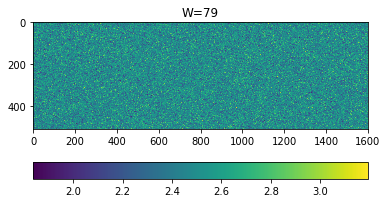

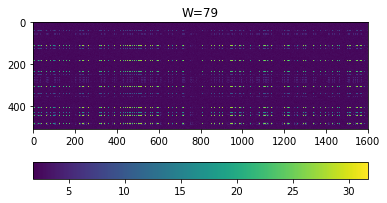

In [121]:
plt.title('W=' + str(i))
plt.imshow(sim.data[weights_probe][0])
plt.colorbar(orientation='horizontal')
plt.show()

plt.title('W=' + str(i))
plt.imshow(sim.data[weights_probe][79])
plt.colorbar(orientation='horizontal')
plt.show()


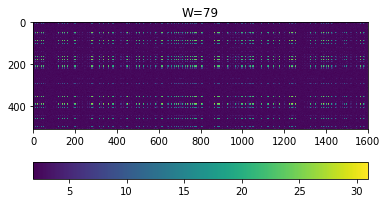

In [39]:
# how the weights are changing over time (as training happens)
for i in range(80):
    plt.title('W=' + str(i))
    plt.imshow(sim.data[weights_probe][i])
    plt.colorbar(orientation='horizontal')
    plt.show()
    clear_output(wait=True)


### Visualization of Wave
Here we plot the neurons that fire for a given time step in each layer. These waves, beginning in the first layer, propagate to higher layers, and wire the layers together. 

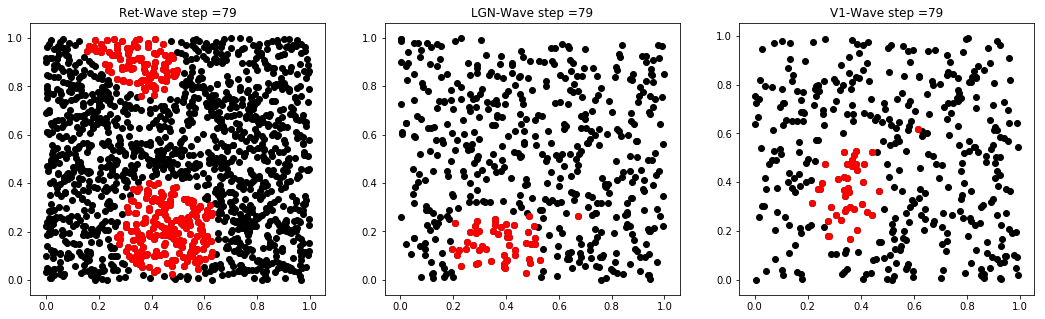

In [124]:
# Visualization of Wave
for t in range(len(sim.trange())):
    plt.figure(figsize=(18, 5))
    plt.subplot(131)
    plt.scatter(retina["nxs"][:,0], retina["nxs"][:,1], color = 'k')
    plt.title('Ret-Wave step =' + str(t))
    fired = np.argwhere(sim.data[spikes_probe][t,:])
    plt.scatter(retina["nxs"][fired,0], retina["nxs"][fired,1], color = 'r')
    
    plt.subplot(132)
    plt.scatter(lgn["nxs"][:,0], lgn["nxs"][:,1], color = 'k')
    plt.title('LGN-Wave step =' + str(t))
    fired = np.argwhere(sim.data[b_spikes][t,:])
    plt.scatter(lgn["nxs"][fired,0], lgn["nxs"][fired,1], color = 'r')
    
    plt.subplot(133)
    plt.scatter(v1["nxs"][:,0], v1["nxs"][:,1], color = 'k')
    plt.title('V1-Wave step =' + str(t))
    fired = np.argwhere(sim.data[c_spikes][t,:])
    plt.scatter(v1["nxs"][fired,0], v1["nxs"][fired,1], color = 'r')
    
    plt.show()
    clear_output(wait=True)


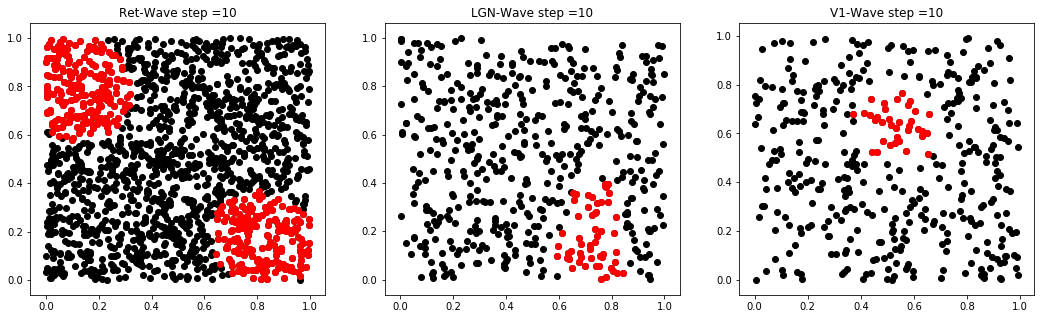

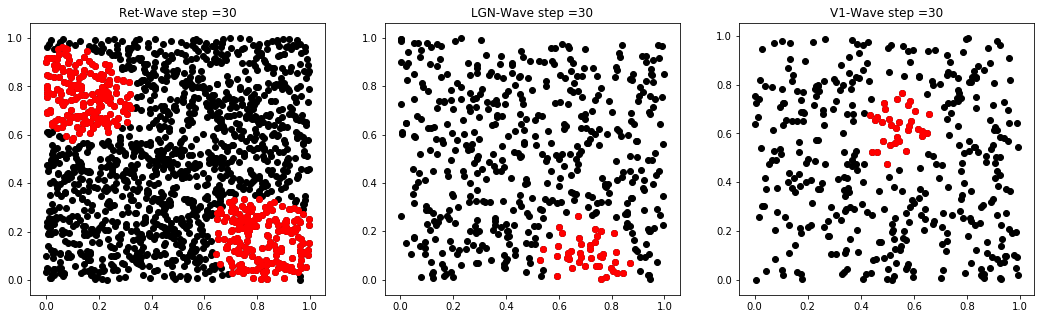

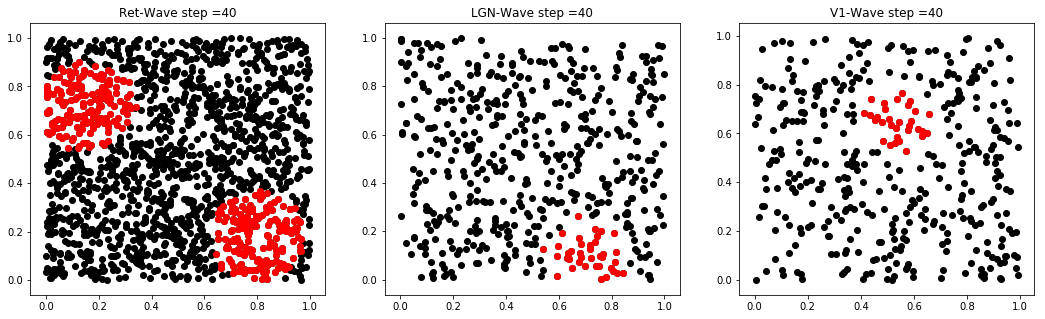

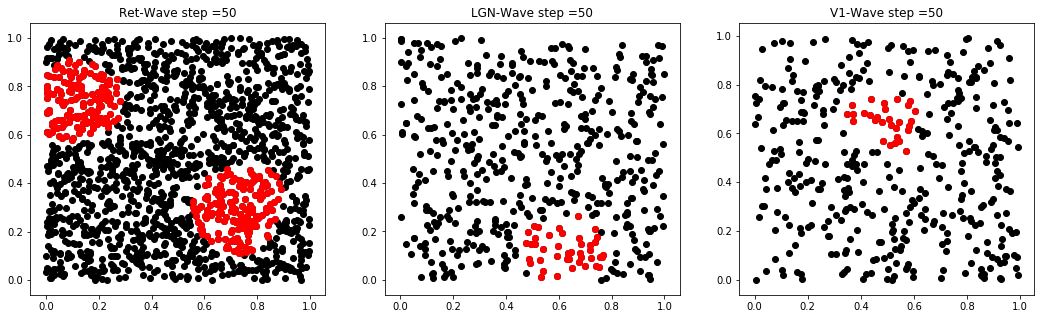

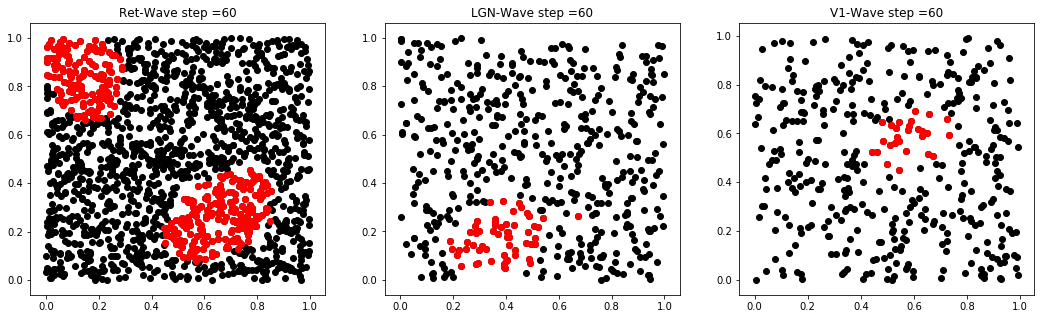

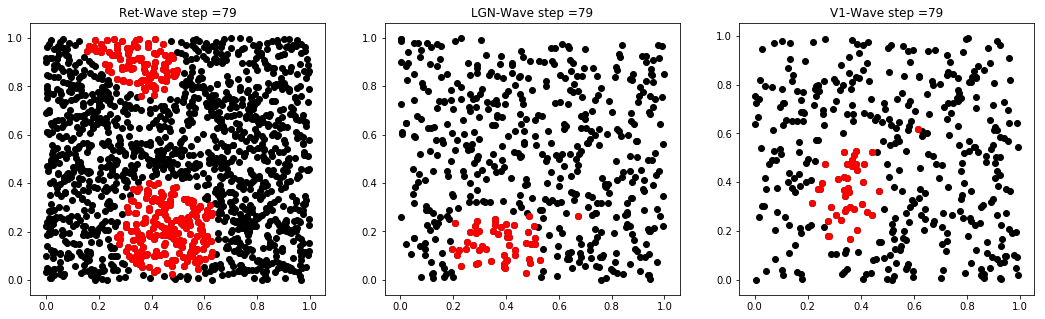

In [131]:
# Visualization of Wave
for t in [10, 30 , 40, 50, 60, 79]:
    plt.figure(figsize=(18, 5))
    plt.subplot(131)
    plt.scatter(retina["nxs"][:,0], retina["nxs"][:,1], color = 'k')
    plt.title('Ret-Wave step =' + str(t))
    fired = np.argwhere(sim.data[spikes_probe][t,:])
    plt.scatter(retina["nxs"][fired,0], retina["nxs"][fired,1], color = 'r')
    
    plt.subplot(132)
    plt.scatter(lgn["nxs"][:,0], lgn["nxs"][:,1], color = 'k')
    plt.title('LGN-Wave step =' + str(t))
    fired = np.argwhere(sim.data[b_spikes][t,:])
    plt.scatter(lgn["nxs"][fired,0], lgn["nxs"][fired,1], color = 'r')
    
    plt.subplot(133)
    plt.scatter(v1["nxs"][:,0], v1["nxs"][:,1], color = 'k')
    plt.title('V1-Wave step =' + str(t))
    fired = np.argwhere(sim.data[c_spikes][t,:])
    plt.scatter(v1["nxs"][fired,0], v1["nxs"][fired,1], color = 'r')
    
    plt.show()
    #clear_output(wait=True)


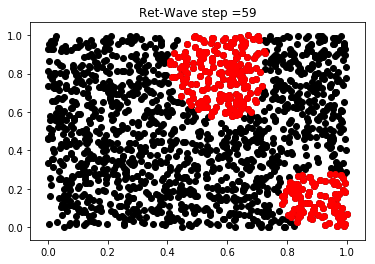

In [38]:
plt.scatter(retina["nxs"][:,0], retina["nxs"][:,1], color = 'k')
plt.title('Ret-Wave step =' + str(t))
fired = np.argwhere(sim.data[spikes_probe][t,:])
plt.scatter(retina["nxs"][fired,0], retina["nxs"][fired,1], color = 'r')
    

No handles with labels found to put in legend.


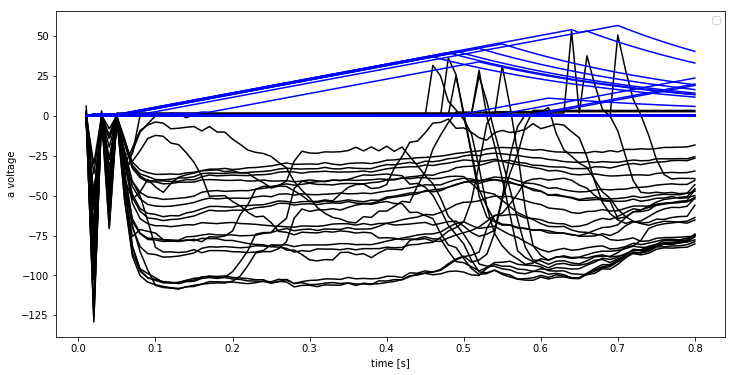

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(sim.trange(), sim.data[voltage_probe][:,:30], c = 'k')
plt.plot(sim.trange(), sim.data[threshold_probe][:,:30], c = 'b')
plt.xlabel('time [s]')
plt.ylabel('a voltage')


Here it seems that the voltage (black) never reaches above the threshold (blue) despite the neurons firing. However, what is actually happening is that Nengo takes the value of the voltage of each neuron at the end of step_math, which is after the voltage is set to its reset value. 

# scratch paper

Text(0, 0.5, 'Neuron number (a spikes)')

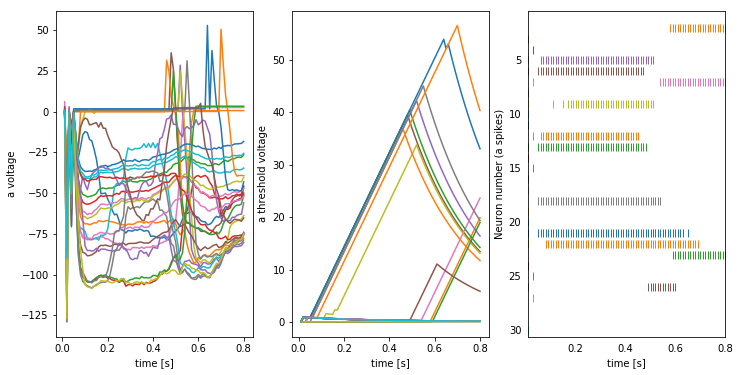

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.plot(sim.trange(), sim.data[voltage_probe][:,:30])
#plt.plot(sim.trange(), sim.data[threshold_probe], label = 'threshold')
plt.xlabel('time [s]')
plt.ylabel('a voltage')
#plt.legend()

plt.subplot(132)
plt.plot(sim.trange(), sim.data[threshold_probe][:,:30])
plt.xlabel('time [s]')
plt.ylabel('a threshold voltage')

plt.subplot(133)
rasterplot(sim.trange(), sim.data[spikes_probe][:,:30])
plt.xlabel('time [s]')
plt.ylabel('Neuron number (a spikes)')

In [ ]:
dp = sim.data[delta_probe][9]
dp[dp!=0]

In [ ]:
dp

In [ ]:
sim.data[weights_probe][:80,1,0]

In [20]:
sim.data[weights_probe][1,0,0]

2.72188898269327

In [ ]:
sim.data[weights_probe][-1].shape

In [ ]:
sim.data[LR_pre]

In [ ]:
sim.data[LR_post]

In [ ]:
conn.learning_rule_type

Text(0, 0.5, 'Neuron number (b spikes)')

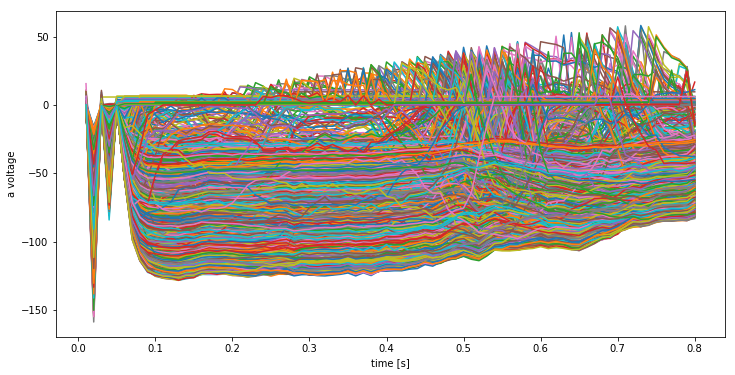

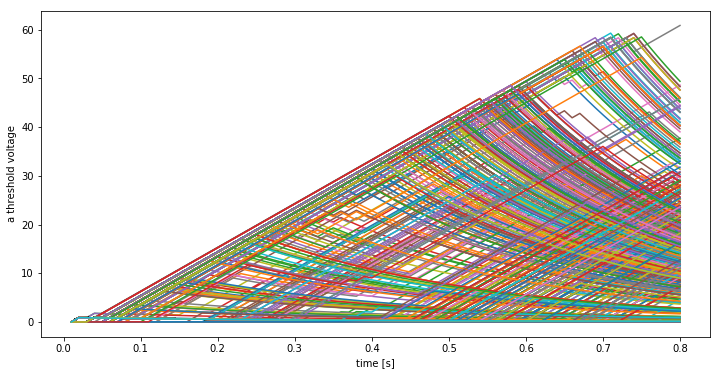

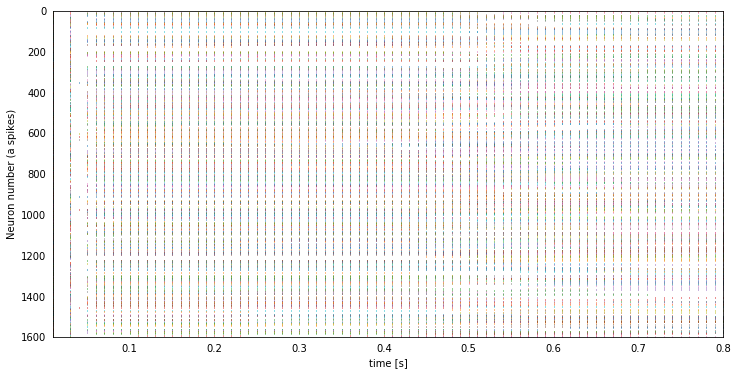

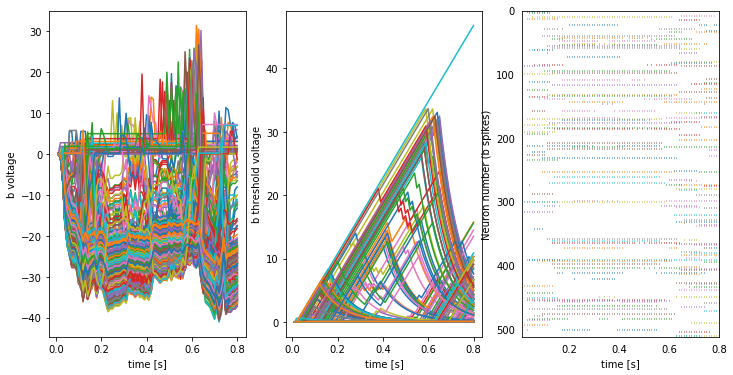

In [17]:
#Plotting Retina

plt.figure(figsize=(12, 6))
# plt.subplot(131)
plt.plot(sim.trange(), sim.data[voltage_probe])
#plt.plot(sim.trange(), sim.data[threshold_probe], label = 'threshold')
plt.xlabel('time [s]')
plt.ylabel('a voltage')
#plt.legend()

# plt.subplot(132)
plt.figure(figsize=(12, 6))
plt.plot(sim.trange(), sim.data[threshold_probe])
plt.xlabel('time [s]')
plt.ylabel('a threshold voltage')

# plt.subplot(133)
plt.figure(figsize=(12, 6))
rasterplot(sim.trange(), sim.data[spikes_probe])
plt.xlabel('time [s]')
plt.ylabel('Neuron number (a spikes)')


               
#Plotting LGN

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.plot(sim.trange(), sim.data[b_voltage])
#plt.plot(sim.trange(), sim.data[threshold_probe], label = 'threshold')
plt.xlabel('time [s]')
plt.ylabel('b voltage')
#plt.legend()

plt.subplot(132)
plt.plot(sim.trange(), sim.data[b_threshold])
plt.xlabel('time [s]')
plt.ylabel('b threshold voltage')

plt.subplot(133)
rasterplot(sim.trange(), sim.data[b_spikes])
plt.xlabel('time [s]')
plt.ylabel('Neuron number (b spikes)')
                 

In [ ]:
conn.probeable